In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model
import re
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [4]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [5]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000 , 
                 precision = None, accuracy=0.00001,beta=0.5,epsilon=1e-8):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.precision = precision
        self.accuracy = accuracy
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
        self.beta = beta;
        
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]        
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X-m)/s**2
        
        return X_new, m, s


    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
       
    def __softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
        
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) / np.sqrt(
                hidden_layers[i - 1]))
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}


    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.__softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads


    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            self.S_dW[i] = self.beta * self.S_dW[i] + (1 - self.beta) * np.power(dW[i], 2)
            self.S_db[i] = self.beta * self.S_db[i] + (1 - self.beta) * np.power(db[i], 2)
            W[i] = W[i] - self.learning_rate * dW[i] / (np.sqrt(self.S_dW[i]) + self.epsilon)
            b[i] = b[i] - self.learning_rate * db[i] / (np.sqrt(self.S_db[i]) + self.epsilon)
            
        self.parameters = {"W" : W, "b" : b}

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        check = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        self.S_dW = list()
        self.S_db = list()
        h = list(self.hidden_layer_sizes)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        for i in range(1, self.n_layers+1):
            self.S_dW.append(np.zeros((hidden_layers[i], hidden_layers[i-1])))
            self.S_db.append(np.zeros((hidden_layers[i], 1)))
        
        for i in range(self.num_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            check.append(cost)
            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()

    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs,cache = self.__forward_propagation(X)
        return probs.T
    
    
    def predict(self, X_vert):
        pp = self.predict_proba(X_vert)
        return np.argmax(pp, axis=1)

In [6]:
HEADERS = [
    'From', 'Subject', 'To', 'Reply-To', 'In-Reply-To', 'Apparently-To',
    'Original-Sender', 'Originator', 'Moderator', 'Organization', 'Keywords',
    'Distribution', 'NNTP-Posting-Host', 'Lines', 'Summary', 'Supersedes',
    'X-Bytes', 'X-Disclaimer', 'X-Mailer', 'X-Newsreader', 'X-News-Reader',
    'X-Gated-By', 'X-Added', 'X-Status',
    'OD-Comment-To', 'Expires', 'Disclaimer', 'Article-I.D.', 
    'News-Software',  'Nf-ID', 'Mime-Version'
]

RE_EMAIL = re.compile('<?.*@.*>?', re.M)
RE_LINE_BREAK = re.compile('\\n+', re.M)
RE_CITATION = re.compile('^.*writes:$', re.M)
RE_CITATION_QUOTES = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
RE_HEADERS = re.compile('^(%s):.*$' % '|'.join(HEADERS), re.M|re.I)
def _clean(docs):
    docs = map(rm_headers, docs)
    docs = map(rm_citation, docs)
    docs = map(rm_citation_quotes, docs)
    docs = map(rm_email, docs)
    docs = map(rm_line_break, docs)
    
    return list(docs)

def rm_citation(doc):
    return RE_CITATION.sub('', doc)

def rm_citation_quotes(doc):
    return RE_CITATION_QUOTES.sub(r'\1', doc)

def rm_email(doc):
    return RE_EMAIL.sub('<email>', doc)

def rm_line_break(doc):
    return RE_LINE_BREAK.sub(' ', doc).strip('\n\t ')

def rm_headers(doc):
    return RE_HEADERS.sub('', doc)

In [7]:
ng = fetch_20newsgroups(subset="all", shuffle=False)
df=pd.DataFrame.from_dict({
        'text': _clean(ng.data),
        'group': np.take(ng.target_names, ng.target)
    })

In [8]:
df.describe(include='all')

,text,group
count,18846,18846
unique,18750,20
top,,rec.sport.hockey
freq,30,999


In [9]:
df.head(100)

,text,group
0,morgan and guzman will have era's 1 run higher...,rec.sport.baseball
1,"Well, I just got my Centris 610 yesterday. It...",comp.sys.mac.hardware
2,History and classical methods. Modern methods....,sci.crypt
3,ATTENTION: Mac Quadra owners: Many storage ind...,comp.sys.mac.hardware
4,To show that the examples I and others have pr...,alt.atheism
...,...,...
95,"Similarly, I have trained myself to hold down ...",comp.sys.mac.hardware
96,. . I have a friend who connects to the mainfr...,comp.os.ms-windows.misc
97,<email> During the nuclear fission reaction th...,sci.electronics
98,Les Bartel's comments: >>>Sorry I can't help y...,rec.autos


In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.group)

In [11]:
train.group.value_counts()

rec.sport.hockey            799
soc.religion.christian      798
rec.motorcycles             797
rec.sport.baseball          795
sci.crypt                   793
rec.autos                   792
sci.med                     792
sci.space                   790
comp.windows.x              790
comp.os.ms-windows.misc     788
sci.electronics             787
comp.sys.ibm.pc.hardware    786
misc.forsale                780
comp.graphics               778
comp.sys.mac.hardware       770
talk.politics.mideast       752
talk.politics.guns          728
alt.atheism                 639
talk.politics.misc          620
talk.religion.misc          502
Name: group, dtype: int64

In [12]:
label_encoder = LabelEncoder().fit(train.group)

In [13]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [14]:
Y_train = label_encoder.transform(train.group)
print('Y_train shape: %s' % (Y_train.shape,))

Y_test = label_encoder.transform(test.group)
print('Y_test shape: %s' % (Y_test.shape,))

Y_train shape: (15076,)
Y_test shape: (3770,)


In [15]:
#компутер не посилив велике число фіч
tfidf = TfidfVectorizer(max_features=100).fit(train.text)
len(tfidf.vocabulary_)

100

In [16]:
X_train = tfidf.transform(train.text).toarray()
print('X_train shape: %s' % (X_train.shape,))

X_test = tfidf.transform(test.text).toarray()
print('X_test shape: %s' % (X_test.shape,))

X_train shape: (15076, 100)
X_test shape: (3770, 100)


In [17]:
label_encoder = LabelEncoder().fit(train.group)

Y_train = label_encoder.transform(train.group)
print('Y_train shape: %s' % (Y_train.shape,))

Y_test = label_encoder.transform(test.group)
print('Y_test shape: %s' % (Y_test.shape,))

Y_train shape: (15076,)
Y_test shape: (3770,)


# MultinomialNB

In [18]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, Y_train)

In [19]:
print(classification_report(Y_train, clf.predict(X_train), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.36      0.09      0.15       639
           comp.graphics       0.23      0.27      0.25       778
 comp.os.ms-windows.misc       0.26      0.19      0.22       788
comp.sys.ibm.pc.hardware       0.26      0.22      0.24       786
   comp.sys.mac.hardware       0.21      0.08      0.11       770
          comp.windows.x       0.26      0.42      0.32       790
            misc.forsale       0.47      0.68      0.56       780
               rec.autos       0.22      0.18      0.20       792
         rec.motorcycles       0.28      0.37      0.32       797
      rec.sport.baseball       0.29      0.37      0.33       795
        rec.sport.hockey       0.31      0.34      0.32       799
               sci.crypt       0.25      0.40      0.31       793
         sci.electronics       0.25      0.20      0.22       787
                 sci.med       0.24      0.24      0.24       792
         

/home/dimulya/.pyenv/versions/3.8.1/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print(classification_report(Y_test, clf.predict(X_test), target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.44      0.09      0.15       160
           comp.graphics       0.19      0.23      0.21       195
 comp.os.ms-windows.misc       0.16      0.12      0.14       197
comp.sys.ibm.pc.hardware       0.28      0.23      0.25       196
   comp.sys.mac.hardware       0.16      0.06      0.09       193
          comp.windows.x       0.18      0.32      0.23       198
            misc.forsale       0.47      0.70      0.56       195
               rec.autos       0.24      0.18      0.21       198
         rec.motorcycles       0.23      0.31      0.27       199
      rec.sport.baseball       0.33      0.41      0.37       199
        rec.sport.hockey       0.26      0.29      0.27       200
               sci.crypt       0.22      0.36      0.28       198
         sci.electronics       0.16      0.13      0.14       197
                 sci.med       0.20      0.21      0.21       198
         

/home/dimulya/.pyenv/versions/3.8.1/envs/jupyter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
pred = clf.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, pred)

0.2676392572944297

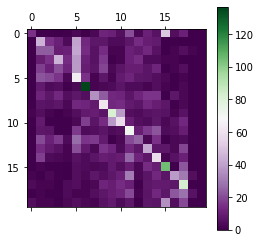

In [25]:
import seaborn as sns
cm = confusion_matrix(Y_test, pred) 
plt.matshow(cm, cmap=plt.cm.PRGn)
plt.colorbar()

# Custom Classifier

In [26]:
cls = NeuralNet(hidden_layer_sizes = [50,], 
                normalize = True, 
                learning_rate = 0.001, 
                num_iter = 100, 
                beta = 0.3, 
                epsilon=1e-8, 
                accuracy=0.0001)  

In [27]:
encoder = OneHotEncoder()
Y_train_e = encoder.fit_transform(Y_train.reshape((Y_train.shape[0], 1))).toarray()

0-th iteration: 0.16112188132848576
10-th iteration: 0.15282592963096328
20-th iteration: 0.1470566016749202
30-th iteration: 0.1424245671363695
40-th iteration: 0.13827883983517533
50-th iteration: 0.13450444321689362
60-th iteration: 0.13100702441643458
70-th iteration: 0.12782404527356264
80-th iteration: 0.12491803125465538
90-th iteration: 0.12226576312510157


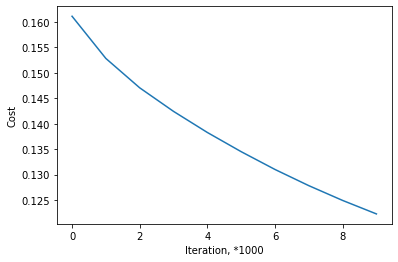

In [28]:
cls.fit(X_train, Y_train_e)

In [29]:
y_train_pred = np.array(cls.predict(X_train))
print(Y_train.shape)
accuracy_ts = accuracy_score(Y_train, y_train_pred)
precision_ts = precision_score(Y_train, y_train_pred, average='micro')
recall_ts = recall_score(Y_train, y_train_pred, average='micro')
print('Accuracy       : ', accuracy_ts)
print('Precision      : ', precision_ts)
print('Recall         : ', recall_ts)

(15076,)
Accuracy       :  0.28343061820111437
Precision      :  0.28343061820111437
Recall         :  0.28343061820111437


In [30]:
print(classification_report(Y_train, y_train_pred,target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

             alt.atheism       0.31      0.28      0.29       639
           comp.graphics       0.23      0.18      0.20       778
 comp.os.ms-windows.misc       0.23      0.22      0.22       788
comp.sys.ibm.pc.hardware       0.22      0.15      0.18       786
   comp.sys.mac.hardware       0.21      0.21      0.21       770
          comp.windows.x       0.28      0.37      0.32       790
            misc.forsale       0.39      0.66      0.49       780
               rec.autos       0.26      0.16      0.19       792
         rec.motorcycles       0.31      0.28      0.29       797
      rec.sport.baseball       0.30      0.34      0.32       795
        rec.sport.hockey       0.27      0.39      0.32       799
               sci.crypt       0.29      0.32      0.30       793
         sci.electronics       0.26      0.19      0.22       787
                 sci.med       0.26      0.25      0.25       792
         

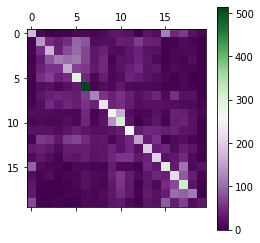

In [31]:
cm = confusion_matrix(Y_train, y_train_pred) 
plt.matshow(cm, cmap=plt.cm.PRGn)
plt.colorbar()